In [145]:
using CBFToolbox
using LinearAlgebra
using Zygote

In [146]:
# Two-link parameters
p1 = 3.473
p2 = 0.196
p3 = 0.242
fd1 = 5.3
fd2 = 1.1

1.1

In [147]:
# Two-link dynamics
M(q) = [p1 + 2*p3*cos(q[2]) p2 + p3*cos(q[2]); p2 + p3*cos(q[2]) p2]
C(q, q̇) = [-p3*sin(q[2])*q̇[2]  -p3*sin(q[2])*(q̇[1] + q̇[2]); p3*sin(q[2])*q̇[1] 0.0]
Fd(q̇) = [fd1*q̇[1], fd2*q̇[2]]

Fd (generic function with 1 method)

In [148]:
# Put into control affine form
n = 4
m = 2
f(x) = vcat(x[3:4], -M(x[3:4])\(C(x[1:2], x[3:4])*x[3:4] + Fd(x[3:4])))
g(x) = vcat(zeros(2,2), inv(M(x[3:4])))
Σ = ControlAffineSystem(n, m, f, g)

ControlAffineSystem(4, 2, f, g, [0.0, 0.0, 0.0, 0.0], missing, missing)

In [149]:
# Define reference trajectory
qd1(t) = exp(-0.05t) * (π/2) * cos(t)
qd2(t) = exp(-0.05t) * (π/3) * sin(t)
qd(t) = [qd1(t), qd2(t)]
q̇d1(t) = gradient(s -> qd1(s), t)[1]
q̇d2(t) = gradient(s -> qd2(s), t)[1]
q̇d(t) = [q̇d1(t), q̇d2(t)]

q̇d (generic function with 1 method)

In [150]:
# Define CLF
function V(x, t)
    # Pull out states
    q = x[1:2]
    q̇ = x[3:4]

    # Compute tracking errors
    α = 10.0
    e = q - qd(t)
    ė = q̇ - q̇d(t)
    r = ė + α*e

    return 0.5*r'M(q)*r + 0.5e'e
end
α(r) = 3r
CLF = TimeVaryingCLF(V, α)
k = TimeVaryingCLFQP(Σ, CLF)

TimeVaryingCLFQP(CBFToolbox.var"#control#33"{ControlAffineSystem, TimeVaryingCLF}(ControlAffineSystem(4, 2, f, g, [0.0, 0.0, 0.0, 0.0], missing, missing), TimeVaryingCLF(V, CBFToolbox.var"#∇V#19"{typeof(V)}(V), CBFToolbox.var"#∂ₜV#21"{typeof(V)}(V), α)))

In [151]:
# Define CBFs

# Link 1 remain less than 0.6
h1(x) = 0.6 - x[1]
α1(s) = 10s^3
CBF1 = ControlBarrierFunction(h1, α1)
HOCBF1 = HighOrderCBF(CBF1, Σ, 2)

# Link 1 remain greater than -0.6
h2(x) = 0.6 + x[1]
α2(s) = 10s^3
CBF2 = ControlBarrierFunction(h2, α2)
HOCBF2 = HighOrderCBF(CBF2, Σ, 2)

# Link 2 remain less than 0.4
h3(x) = 0.4 - x[2]
α3(s) = 10s^3
CBF3 = ControlBarrierFunction(h3, α3)
HOCBF3 = HighOrderCBF(CBF3, Σ, 2)

# Link 1 remain greater than -0.6
h4(x) = 0.4 + x[2]
α4(s) = 10s^3
CBF4 = ControlBarrierFunction(h4, α4)
HOCBF4 = HighOrderCBF(CBF4, Σ, 2)

# Final policy
HOCBFs = [HOCBF1, HOCBF2, HOCBF3, HOCBF4]
kCBF = TimeVaryingCBFQP(Σ, HOCBFs, k)

TimeVaryingCBFQP(CBFToolbox.var"#control#150"{ControlAffineSystem, Vector{HighOrderCBF}, TimeVaryingCLFQP}(ControlAffineSystem(4, 2, f, g, [0.0, 0.0, 0.0, 0.0], missing, missing), HighOrderCBF[HighOrderCBF(CBFToolbox.var"#ψ1#87"{ControlBarrierFunction, ControlAffineSystem}(ControlBarrierFunction(h1, CBFToolbox.var"#∇h#41"{typeof(h1)}(h1), α1), ControlAffineSystem(4, 2, f, g, [0.0, 0.0, 0.0, 0.0], missing, missing)), CBFToolbox.var"#∇ψ1#88"{ControlBarrierFunction, ControlAffineSystem, CBFToolbox.var"#dα#86"{ControlBarrierFunction}, CBFToolbox.var"#dh2dx2#85"{ControlBarrierFunction}, CBFToolbox.var"#dfdx#84"{ControlAffineSystem}}(ControlBarrierFunction(h1, CBFToolbox.var"#∇h#41"{typeof(h1)}(h1), α1), ControlAffineSystem(4, 2, f, g, [0.0, 0.0, 0.0, 0.0], missing, missing), CBFToolbox.var"#dα#86"{ControlBarrierFunction}(ControlBarrierFunction(h1, CBFToolbox.var"#∇h#41"{typeof(h1)}(h1), α1)), CBFToolbox.var"#dh2dx2#85"{ControlBarrierFunction}(ControlBarrierFunction(h1, CBFToolbox.var"#∇h#41

In [152]:
# Set up simulation
t0 = 0.0
tf = 50.0
dt = 0.01
sim = Simulation(t0, tf ,dt)
Σ.x0 = [0.0, 0.0, 0.0, 0.0]

4-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0

In [153]:
# Run simulation
sim(Σ, kCBF)

ControlAffineSystem(4, 2, f, g, [0.0, 0.0, 0.0, 0.0], [0.12524593373153084, -0.02305813813472931, 0.031045947795981646, 0.08116021766576453], [0.0 0.0011308941869760283 … 0.12493337728902731 0.12524593373153084; 0.0 -0.00011306808987793346 … -0.0239245311314852 -0.02305813813472931; 0.0 0.22548119360705965 … 0.03145148119475295 0.031045947795981646; 0.0 -0.020849195733447408 … 0.09225311653763424 0.08116021766576453])

In [154]:
# Set up plots
using Plots
using LaTeXStrings
custom_plots()

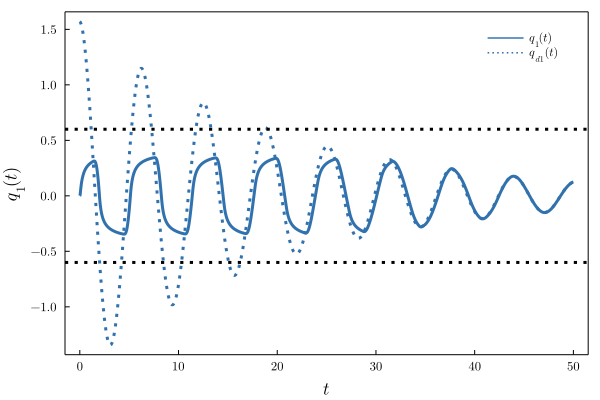

In [155]:
fig1 = plot(xlabel=L"t", ylabel=L"q_1(t)")
plot!(sim.ts, Σ.xs[1,:], c=1, label=L"q_1(t)")
plot!(sim.ts, [qd1(t) for t in sim.ts], c=1, ls=:dot, label=L"q_{d1}(t)")
hline!([0.6, -0.6], c=:black, ls=:dot)

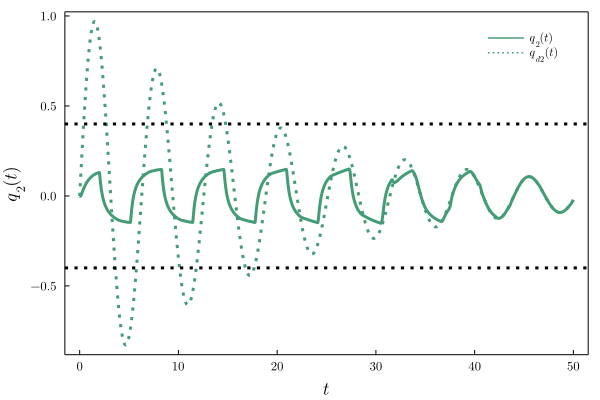

In [156]:
fig2 = plot(xlabel=L"t", ylabel=L"q_2(t)")
# plot!(sim.ts, Σ.xs[1,:], c=1, label=L"q_1(t)")
plot!(sim.ts, Σ.xs[2,:], c=2, label=L"q_2(t)")
# plot!(sim.ts, [qd1(t) for t in sim.ts], c=1, ls=:dot, label=L"q_{d1}(t)")
plot!(sim.ts, [qd2(t) for t in sim.ts], c=2, ls=:dot, label=L"q_{d2}(t)")
hline!([0.4, -0.4], c=:black, ls=:dot)